# I. Importing the required libraries

In [1]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


# II. Reading the data

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


path source actor gender intensity  \
0  data/Actor_01/03-01-01-01-01-01-01.wav      1     1   male         0   
1  data/Actor_01/03-01-01-01-01-02-01.wav      1     1   male         0   
2  data/Actor_01/03-01-01-01-02-01-01.wav      1     1   male         0   
3  data/Actor_01/03-01-01-01-02-02-01.wav      1     1   male         0   
4  data/Actor_01/03-01-02-01-01-01-01.wav      1     1   male         0   

  statement repetition emotion  
0         0          0       1  
1         0          1       1  
2         1          0       1  
3         1          1       1  
4         0          0       2

# III. Plotting the audio file's waveform and its spectrogram

In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

data/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [6]:
len(samples), sample_rate

(77989, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5, 0, 'Seconds')

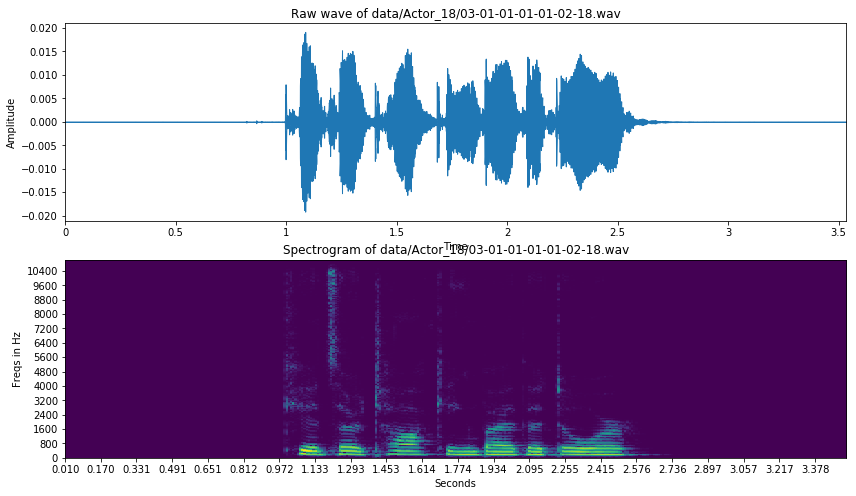

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

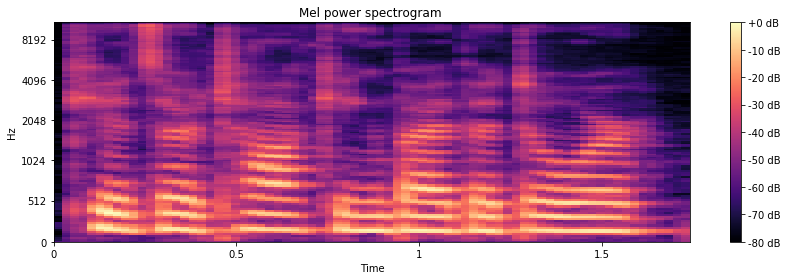

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\jimmy\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



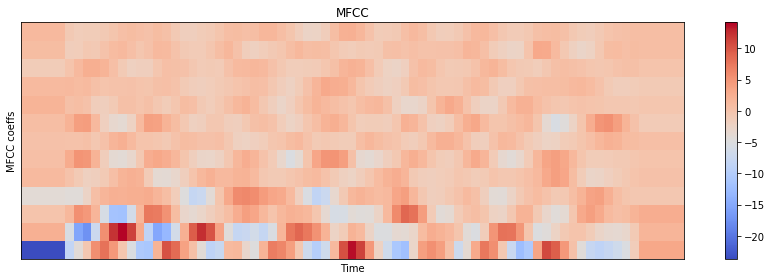

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [23]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [24]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [25]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

path source actor gender intensity  \
0  data/Actor_01/03-01-01-01-01-01-01.wav      1     1   male         0   
1  data/Actor_01/03-01-01-01-01-02-01.wav      1     1   male         0   
2  data/Actor_01/03-01-01-01-02-01-01.wav      1     1   male         0   
3  data/Actor_01/03-01-01-01-02-02-01.wav      1     1   male         0   
4  data/Actor_01/03-01-02-01-01-01-01.wav      1     1   male         0   

  statement repetition emotion          label  
0         0          0       1      male_none  
1         0          1       1      male_none  
2         1          0       1      male_none  
3         1          1       1      male_none  
4         0          0       2  male_positive

In [26]:
print (data_df.label.value_counts().keys())

Index(['female_negative', 'male_negative', 'male_none', 'female_none',
       'male_positive', 'female_positive'],
      dtype='object')


In [27]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

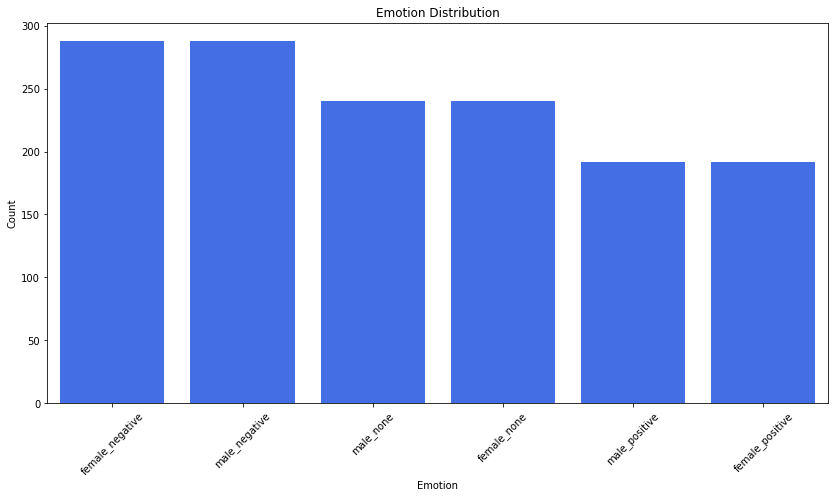

In [28]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [29]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


path source actor  gender intensity  \
0  data/Actor_02/03-01-02-01-01-01-02.wav      1     2  female         0   
1  data/Actor_02/03-01-02-01-01-02-02.wav      1     2  female         0   
2  data/Actor_02/03-01-02-01-02-01-02.wav      1     2  female         0   
3  data/Actor_02/03-01-02-01-02-02-02.wav      1     2  female         0   
4  data/Actor_02/03-01-02-02-01-01-02.wav      1     2  female         1   

  statement repetition emotion            label  
0         0          0       2  female_positive  
1         0          1       2  female_positive  
2         1          0       2  female_positive  
3         1          1       2  female_positive  
4         0          0       2  female_positive

In [89]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


path source actor gender intensity  \
0  data/Actor_01/03-01-02-01-01-01-01.wav      1     1   male         0   
1  data/Actor_01/03-01-02-01-01-02-01.wav      1     1   male         0   
2  data/Actor_01/03-01-02-01-02-01-01.wav      1     1   male         0   
3  data/Actor_01/03-01-02-01-02-02-01.wav      1     1   male         0   
4  data/Actor_01/03-01-02-02-01-01-01.wav      1     1   male         1   

  statement repetition emotion          label  
0         0          0       2  male_positive  
1         0          1       2  male_positive  
2         1          0       2  male_positive  
3         1          1       2  male_positive  
4         0          0       2  male_positive

In [90]:
print (len(data3_df))
data3_df.head()

80


path source actor gender intensity  \
0  data/Actor_21/03-01-02-01-01-01-21.wav      1    21   male         0   
1  data/Actor_21/03-01-02-01-01-02-21.wav      1    21   male         0   
2  data/Actor_21/03-01-02-01-02-01-21.wav      1    21   male         0   
3  data/Actor_21/03-01-02-01-02-02-21.wav      1    21   male         0   
4  data/Actor_21/03-01-02-02-01-01-21.wav      1    21   male         1   

  statement repetition emotion          label  
0         0          0       2  male_positive  
1         0          1       2  male_positive  
2         1          0       2  male_positive  
3         1          1       2  male_positive  
4         0          0       2  male_positive

# VI. Getting the features of audio files using librosa

In [91]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:24<00:00, 17.37it/s]


In [92]:
data.head()

feature
0  [-70.2677641610773, -70.2677641610773, -70.267...
1  [-67.55739512198222, -67.55739512198222, -67.5...
2  [-69.67328949566406, -69.69331084873151, -69.6...
3  [-69.05139995492158, -69.05139995492158, -69.0...
4  [-73.8413701111492, -73.8413701111492, -73.841...

In [93]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [94]:
df3.head()

0          1          2          3          4          5    \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

         6          7          8          9      ...            249  \
0 -70.267764 -70.267764 -70.267764 -70.267764    ...     -70.267764   
1 -65.239801 -65.536197 -67.557395 -67.557395    ...     -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572    ...     -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101    ...     -65.446950   
4 -73.841370 -73.303635 -72.806811 -73.841370    ...     -73.841370   

         250        251        252        253        254        255  \
0 -70.267764 -69.957707 -68.377602 -69.862569 -70.267764 -70.122135   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.693311 -69.693311 -69.693311 -69.693311 -69.383522 -69.693311   
3 -68.552088 -69.051400 -69.051400 -69.051400 -68.688614 -69.051400   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         256        257        258  
0 -68.554960 -70.206530 -70.267764  
1 -67.557395 -67.126574 -67.557395  
2 -69.693311 -69.693311 -69.693311  
3        NaN        NaN        NaN  
4 -73.841370 -73.841370 -73.841370  

[5 rows x 259 columns]

In [95]:
newdf = pd.concat([df3,labels], axis=1)

In [96]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [97]:
rnewdf.head(10)

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   
5 -69.243253 -69.243253 -69.243253 -69.243253 -68.901972 -67.982999   
6 -73.254968 -73.254968 -73.254968 -73.254968 -68.774422 -69.380388   
7 -70.746514 -70.746514 -70.025286 -69.131263 -70.746514 -70.746514   
8 -63.311078 -63.072484 -63.412433 -63.796762 -63.581991 -58.921211   
9 -60.369038 -60.083715 -60.978925 -60.952456 -60.982486 -60.983948   

           6          7          8          9      ...              250  \
0 -70.267764 -70.267764 -70.267764 -70.267764      ...       -70.267764   
1 -65.239801 -65.536197 -67.557395 -67.557395      ...       -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572      ...       -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101      ...       -68.552088   
4 -73.841370 -73.303635 -72.806811 -73.841370      ...       -73.841370   
5 -68.089201 -67.897329 -65.258010 -67.170980      ...       -57.185978   
6 -73.254968 -73.254968 -73.254968 -73.254968      ...       -50.884085   
7 -70.746514 -70.746514 -70.746514 -70.746514      ...       -70.746514   
8 -57.955046 -61.224968 -63.782931 -63.796762      ...       -63.740612   
9 -60.981255 -60.981255 -60.981255 -60.249618      ...       -60.981255   

         251        252        253        254        255        256  \
0 -69.957707 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.693311 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.688614 -69.051400        NaN   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   
5 -61.188731 -67.108389 -67.508122 -66.245553 -68.733048 -69.243253   
6 -55.666730 -54.600013 -53.439110 -56.300120 -57.458272 -58.767075   
7 -70.746514 -70.079249 -69.590462 -69.202740 -70.159467 -70.445363   
8 -62.410257 -62.489080 -62.494456 -62.632636 -62.824277        NaN   
9 -60.981255 -60.981255 -60.981255 -60.981255 -60.981255        NaN   

         257        258          label  
0 -70.206530 -70.267764  male_positive  
1 -67.126574 -67.557395  male_positive  
2 -69.693311 -69.693311  male_positive  
3        NaN        NaN  male_positive  
4 -73.841370 -73.841370  male_positive  
5 -69.243253 -69.243253  male_positive  
6 -59.836503 -58.409867  male_positive  
7 -68.199043 -67.414208  male_positive  
8        NaN        NaN  male_positive  
9        NaN        NaN  male_positive  

[10 rows x 260 columns]

In [98]:
rnewdf.isnull().sum().sum()

2284

In [99]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

           6          7          8          9      ...              250  \
0 -70.267764 -70.267764 -70.267764 -70.267764      ...       -70.267764   
1 -65.239801 -65.536197 -67.557395 -67.557395      ...       -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572      ...       -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101      ...       -68.552088   
4 -73.841370 -73.303635 -72.806811 -73.841370      ...       -73.841370   

         251        252        253        254        255        256  \
0 -69.957707 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.693311 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.688614 -69.051400   0.000000   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         257        258          label  
0 -70.206530 -70.267764  male_positive  
1 -67.126574 -67.557395  male_positive  
2 -69.693311 -69.693311  male_positive  
3   0.000000   0.000000  male_positive  
4 -73.841370 -73.841370  male_positive  

[5 rows x 260 columns]

# VII. Data Augmentation

In [40]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




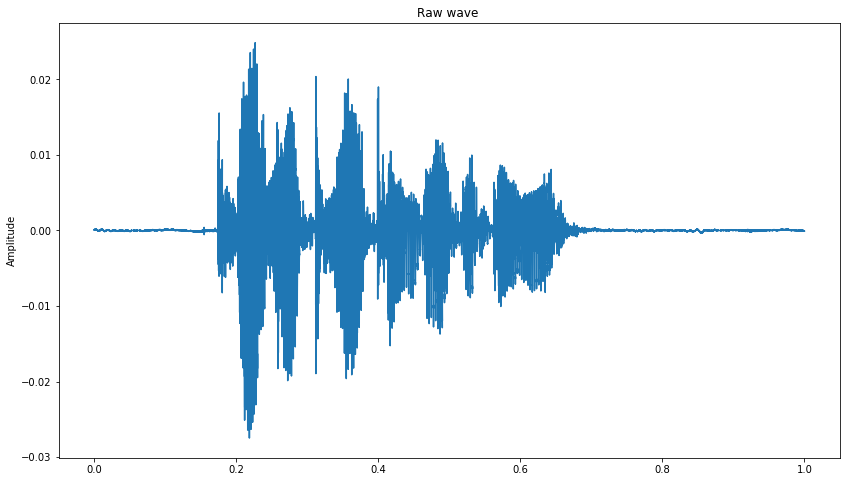

In [100]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

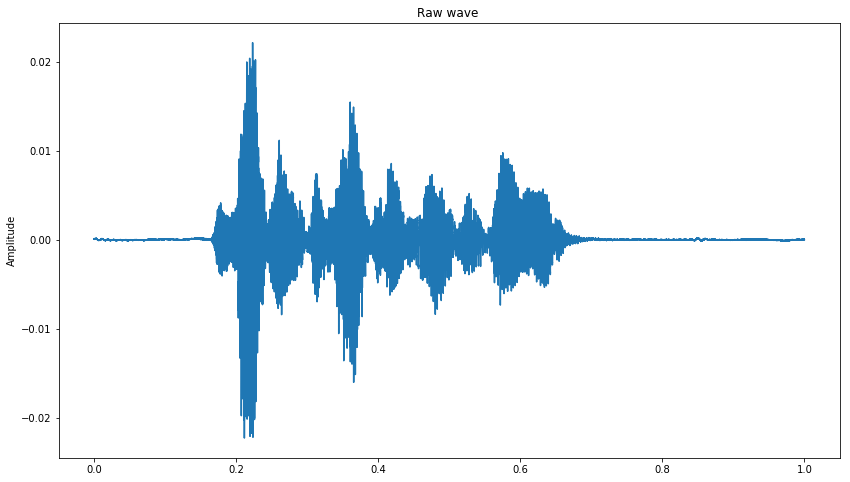

In [101]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [102]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 400/400 [00:25<00:00, 15.34it/s]


In [103]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 400/400 [01:35<00:00,  4.37it/s]


In [104]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [105]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [106]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [107]:
syndf1.head()

0          1          2          3          4          5  \
0 -60.182051 -58.117166 -58.369978 -57.745145 -56.251586 -56.962396   
1 -67.683375 -67.296194 -66.229817 -66.965311 -66.143959 -65.626530   
2 -54.236939 -54.261210 -56.668369 -57.761928 -57.187928 -58.614347   
3 -54.730203 -54.156435 -54.802085 -52.028497 -52.576125 -53.800330   
4 -56.734252 -56.783589 -57.226110 -57.258337 -55.681235 -52.502595   

           6          7          8          9      ...              250  \
0 -59.327271 -58.484776 -57.678923 -57.873383      ...       -59.587469   
1 -64.647545 -63.854617 -66.518488 -66.293804      ...       -66.937795   
2 -58.185813 -58.328112 -57.191179 -55.921943      ...       -57.200956   
3 -51.643633 -51.629818 -52.309757 -51.927829      ...       -50.962930   
4 -54.307751 -55.374062 -56.117597 -59.825737      ...       -57.145136   

         251        252        253        254        255        256  \
0 -59.988579 -58.260270 -56.493974 -55.495719 -57.909146 -59.712433   
1 -67.204075 -67.434871 -67.094666 -66.087321 -65.232261 -66.541181   
2 -56.756710 -57.503389 -57.787787 -54.886599 -53.712429 -56.648883   
3 -53.486098 -52.132062 -51.323519 -50.473240 -50.679438   0.000000   
4 -58.761933 -57.046106 -57.392087 -60.048381 -59.130028 -56.845604   

         257        258          label  
0 -57.845471 -58.981049  male_positive  
1 -66.935943 -65.994166  male_positive  
2 -59.739390 -60.516950  male_positive  
3   0.000000   0.000000  male_positive  
4 -55.362638 -58.250624  male_positive  

[5 rows x 260 columns]

In [108]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [109]:
syndf2.head()

0          1          2          3          4          5  \
0 -70.726569 -70.726569 -70.726569 -70.726569 -70.726569 -70.726569   
1 -69.984891 -69.984891 -69.904577 -69.984891 -69.984891 -69.770850   
2 -71.181455 -71.483948 -71.762365 -71.762365 -71.762365 -71.762365   
3 -70.053410 -70.053410 -70.053410 -70.053410 -70.053410 -70.053410   
4 -75.954847 -75.954847 -75.954847 -75.954847 -75.954847 -75.954847   

           6          7          8          9      ...              250  \
0 -70.726569 -70.726569 -70.726569 -70.726569      ...       -70.726569   
1 -67.413591 -69.383499 -69.984891 -69.984891      ...       -69.984891   
2 -71.762365 -71.762365 -71.659095 -70.900970      ...       -71.762365   
3 -70.053410 -70.053410 -70.053410 -69.935976      ...       -69.582117   
4 -75.954847 -75.631421 -74.847477 -75.954847      ...       -75.954847   

         251        252        253        254        255        256  \
0 -70.076103 -70.597671 -70.726569 -70.726569 -70.661296 -70.526060   
1 -69.984891 -69.984891 -69.984891 -69.984891 -69.984891 -69.984891   
2 -71.762365 -71.762365 -71.762365 -71.720913 -71.762365 -71.762365   
3 -70.053410 -70.053410 -70.053410 -70.053410 -70.053410   0.000000   
4 -75.954847 -75.954847 -75.954847 -75.954847 -75.954847 -75.954847   

         257        258          label  
0 -70.726569 -70.726569  male_positive  
1 -69.984891 -69.984891  male_positive  
2 -71.762365 -71.762365  male_positive  
3   0.000000   0.000000  male_positive  
4 -75.954847 -75.954847  male_positive  

[5 rows x 260 columns]

In [110]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

           6          7          8          9      ...              250  \
0 -70.267764 -70.267764 -70.267764 -70.267764      ...       -70.267764   
1 -65.239801 -65.536197 -67.557395 -67.557395      ...       -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572      ...       -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101      ...       -68.552088   
4 -73.841370 -73.303635 -72.806811 -73.841370      ...       -73.841370   

         251        252        253        254        255        256  \
0 -69.957707 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.693311 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.688614 -69.051400   0.000000   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         257        258          label  
0 -70.206530 -70.267764  male_positive  
1 -67.126574 -67.557395  male_positive  
2 -69.693311 -69.693311  male_positive  
3   0.000000   0.000000  male_positive  
4 -73.841370 -73.841370  male_positive  

[5 rows x 260 columns]

In [111]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [112]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [113]:
y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [114]:
X_train.isna().sum().sum()

0

In [115]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [116]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [117]:
X_train.shape

(960, 259)

# VIII. Changing dimension for CNN model

In [118]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [60]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [61]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [66]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [119]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [120]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer="adamax", metrics=['accuracy'])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [125]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=100, epochs=30,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 960 samples, validate on 240 samples
Epoch 1/30
960/960 [==============================] - ETA: 13s - loss: 0.1441 - accuracy: 0.950 - ETA: 12s - loss: 0.1306 - accuracy: 0.960 - ETA: 10s - loss: 0.1174 - accuracy: 0.963 - ETA: 8s - loss: 0.1449 - accuracy: 0.945 - ETA: 6s - loss: 0.1490 - accuracy: 0.94 - ETA: 5s - loss: 0.1427 - accuracy: 0.94 - ETA: 3s - loss: 0.1474 - accuracy: 0.94 - ETA: 2s - loss: 0.1425 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - 15s 16ms/step - loss: 0.1477 - accuracy: 0.9479 - val_loss: 2.6242 - val_accuracy: 0.6083
Epoch 2/30
960/960 [==============================] - ETA: 12s - loss: 0.1349 - accuracy: 0.930 - ETA: 11s - loss: 0.1243 - accuracy: 0.940 - ETA: 9s - loss: 0.1378 - accuracy: 0.943 - ETA: 8s - loss: 0.1345 - accuracy: 0.94 - ETA: 6s - loss: 0.1261 - accuracy: 0.95 - ETA: 5s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 2s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accur

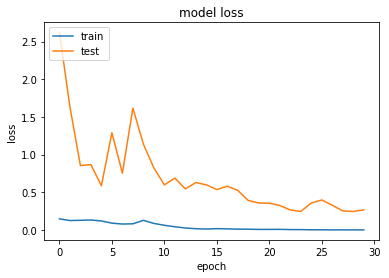

In [126]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [127]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [128]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer="adamax", metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 90.42%


# X. Predicting emotions on the test data

In [130]:
len(data3_df)

80

In [131]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 80/80 [00:04<00:00, 17.78it/s]


In [132]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

80/80 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 5ms/step


In [133]:
preds

array([[9.86237884e-01, 1.37620717e-02],
       [8.64436865e-01, 1.35563090e-01],
       [6.14066422e-01, 3.85933518e-01],
       [6.80679440e-01, 3.19320589e-01],
       [9.99952435e-01, 4.76056848e-05],
       [3.59568442e-03, 9.96404290e-01],
       [4.65872288e-01, 5.34127712e-01],
       [6.06496572e-01, 3.93503398e-01],
       [3.82461622e-02, 9.61753786e-01],
       [4.94476736e-01, 5.05523205e-01],
       [1.72606837e-02, 9.82739329e-01],
       [3.60655218e-01, 6.39344811e-01],
       [2.94867009e-01, 7.05133021e-01],
       [1.45178825e-01, 8.54821146e-01],
       [9.94913220e-01, 5.08677494e-03],
       [7.00582802e-01, 2.99417228e-01],
       [2.77864543e-04, 9.99722064e-01],
       [3.80067853e-04, 9.99619961e-01],
       [2.65352690e-04, 9.99734581e-01],
       [1.48483246e-04, 9.99851465e-01],
       [1.40601798e-04, 9.99859333e-01],
       [1.71381063e-04, 9.99828577e-01],
       [1.81893259e-03, 9.98181105e-01],
       [1.03868544e-03, 9.98961329e-01],
       [1.219621

In [134]:
preds1=preds.argmax(axis=1)

In [135]:
preds1

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [136]:
abc = preds1.astype(int).flatten()

In [137]:
predictions = (lb.inverse_transform((abc)))

In [138]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

predictedvalues
0   male_negative
1   male_negative
2   male_negative
3   male_negative
4   male_negative
5   male_positive
6   male_positive
7   male_negative
8   male_positive
9   male_positive

In [139]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [140]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

actualvalues
0  male_positive
1  male_positive
2  male_positive
3  male_positive
4  male_positive
5  male_positive
6  male_positive
7  male_positive
8  male_positive
9  male_positive

In [141]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [142]:
finaldf[20:40]

actualvalues predictedvalues
20  male_negative   male_positive
21  male_negative   male_positive
22  male_negative   male_positive
23  male_negative   male_positive
24  male_negative   male_positive
25  male_negative   male_positive
26  male_negative   male_negative
27  male_negative   male_negative
28  male_negative   male_negative
29  male_negative   male_negative
30  male_negative   male_negative
31  male_negative   male_negative
32  male_negative   male_negative
33  male_negative   male_positive
34  male_negative   male_positive
35  male_negative   male_positive
36  male_negative   male_negative
37  male_negative   male_negative
38  male_negative   male_negative
39  male_negative   male_negative

In [143]:
finaldf.groupby('actualvalues').count()

predictedvalues
actualvalues                  
male_negative               48
male_positive               32

In [144]:
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
male_negative              46
male_positive              34

In [145]:
finaldf.to_csv('Predictions.csv', index=False)

In [84]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [146]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

57.49999999999999

In [147]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

56.15731785944552

In [148]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[30, 18],
       [16, 16]], dtype=int64)

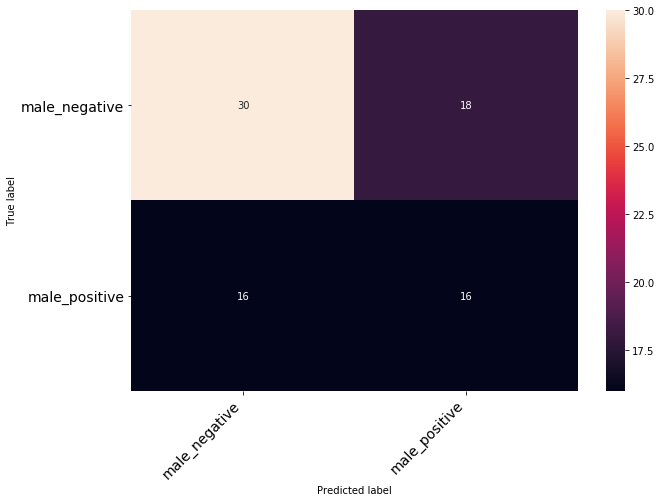

In [149]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_negative', 'female_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)